In [1]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import random
pylab.rcParams['figure.figsize'] = (8.0, 10.0)# Import Libraries

In [2]:
# For visualization
import os
import seaborn as sns
from matplotlib import colors
from tensorboard.backend.event_processing import event_accumulator as ea
from PIL import Image

# Set constant variables

In [3]:
dataDir='C:\\Users\\frank\\OneDrive\\Desktop\\Kaggle\\data\\car_damage\\val'
dataType='COCO_val_annos'
mul_dataType='COCO_mul_val_annos'
annFile='{}/{}.json'.format(dataDir,dataType)
mul_annFile='{}/{}.json'.format(dataDir,mul_dataType)
img_dir = "C:\\Users\\frank\\OneDrive\\Desktop\\Kaggle\\data\\car_damage\\img"

# Initializae the COCO AIP

In [4]:
# load annotation Json file

coco=COCO(annFile)
mul_coco=COCO(mul_annFile)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


# Display damage categories and supercategories

In [5]:
# display categories and supercategories

#Single Class #Damage dataset
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories for damages: \n{}\n'.format(', '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories for damages: \n{}\n'.format(', '.join(nms)))

#Multi Class #Parts dataset

mul_cats = mul_coco.loadCats(mul_coco.getCatIds())
mul_nms=[cat['name'] for cat in mul_cats]
print('COCO categories for parts: \n{}\n'.format(', '.join(mul_nms)))

mul_nms = set([mul_cat['supercategory'] for mul_cat in mul_cats])
print('COCO supercategories for parts: \n{}\n'.format(', '.join(mul_nms)))

COCO categories for damages: 
damage

COCO supercategories for damages: 
part

COCO categories for parts: 
headlamp, rear_bumper, door, hood, front_bumper

COCO supercategories for parts: 
part



In [6]:
# get all images containing 'damage' category, select one at random
catIds = coco.getCatIds(catNms=['damage']);
imgIds = coco.getImgIds(catIds=catIds );

In [7]:
random_img_id = random.choice(imgIds)
print("{} image id was selected at random from the {} list".format(random_img_id, imgIds))

1 image id was selected at random from the [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] list


In [8]:
imgId = coco.getImgIds(imgIds = [random_img_id])
img = coco.loadImgs(imgId)[0]
print("Image details \n",img)

Image details 
 {'coco_url': '', 'date_captured': '2020-07-14 09:59:34.190485', 'file_name': '22.jpg', 'flickr_url': '', 'height': 1024, 'id': 1, 'license': 1, 'width': 1024}


# Raw Image

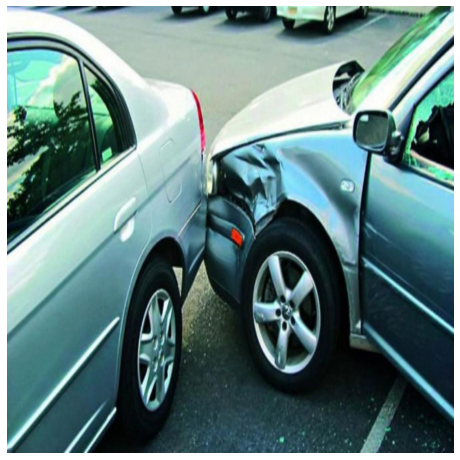

In [9]:
I = io.imread(img_dir + '/' + img['file_name'])
plt.axis('off')
plt.imshow(I)
plt.show()

# Image with damage annotation 

In [10]:
#get damage annotations
annIds = coco.getAnnIds(imgIds=imgId,iscrowd=None)
anns = coco.loadAnns(annIds)

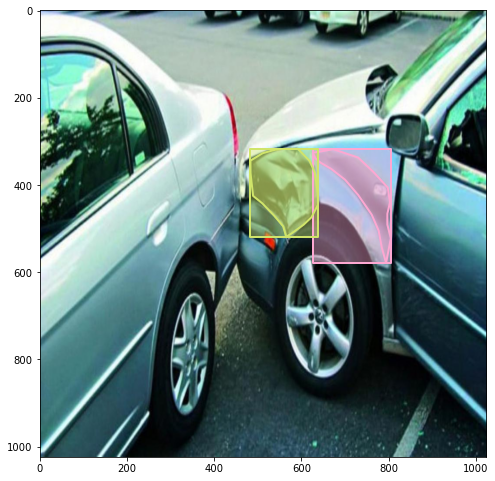

In [11]:
#Plot damages
plt.imshow(I)
plt.axis('on')
coco.showAnns(anns, draw_bbox=True )

# Image with parts annotation

In [12]:
#get parts annotations
mul_annIds = mul_coco.getAnnIds(imgIds=imgId,iscrowd=None)
mul_anns = mul_coco.loadAnns(mul_annIds)

In [13]:
# Create a dictionary between category_id and category name
category_map = dict()

for ele in list(mul_coco.cats.values()):
    category_map.update({ele['id']:ele['name']})

In [14]:
category_map

{1: 'headlamp', 2: 'rear_bumper', 3: 'door', 4: 'hood', 5: 'front_bumper'}

Parts are: ['door', 'rear_bumper', 'headlamp', 'headlamp', 'hood', 'front_bumper', 'door']


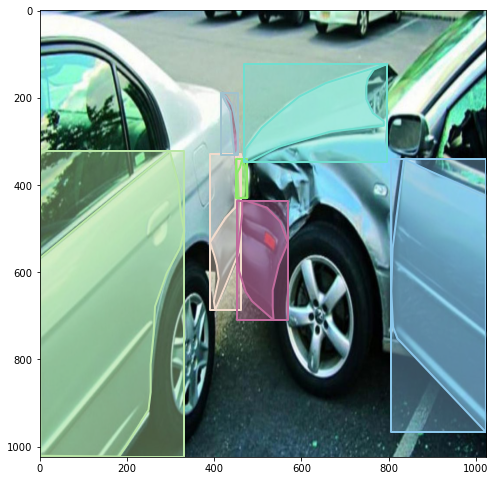

In [15]:
#Create a list of parts in the image
parts = []
for region in mul_anns:
    parts.append(category_map[region['category_id']])

print("Parts are:", parts) 

#Plot Parts
I = io.imread(img_dir + '/' + img['file_name'])
plt.imshow(I)
plt.axis('on')
mul_coco.showAnns(mul_anns, draw_bbox=True )

# Training Objective Detection model using Detectron2

In [16]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

1.9.0 True


In [17]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
import skimage.io as io

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.data.datasets import register_coco_instances

# Set base params
plt.rcParams["figure.figsize"] = [16,9]

## To find out inconsistent CUDA versions, if there is not "failed" word in this output then things are fine.

In [18]:
!python -m detectron2.utils.collect_env

----------------------  ---------------------------------------------------------------------------------------------------
sys.platform            win32
Python                  3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 15:37:01) [MSC v.1916 64 bit (AMD64)]
numpy                   1.19.2
detectron2              0.2.1 @c:\users\frank\detectron2-windows\detectron2
Compiler                MSVC 191627024
CUDA compiler           CUDA 10.2
detectron2 arch flags   c:\users\frank\detectron2-windows\detectron2\_C.cp37-win_amd64.pyd; cannot find cuobjdump
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.9.0 @C:\Users\frank\Anaconda3\envs\detectron\lib\site-packages\torch
PyTorch debug build     False
GPU available           True
GPU 0                   GeForce GTX 1060 6GB
CUDA_HOME               C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v10.2
Pillow                  8.3.1
torchvision             0.10.0 @C:\Users\frank\Anaconda3\envs\detectron\lib\site-package

In [19]:
dataset_dir = 'C:\\Users\\frank\\OneDrive\\Desktop\\Kaggle\\data\\car_damage'
img_dir = "img/"
train_dir = "train/"
val_dir = "val/"

If you want to use a custom dataset while also reusing detectron2’s data loaders, you will need to

- Register your dataset (i.e., tell detectron2 how to obtain your dataset).

- Optionally, register metadata for your dataset.

In [20]:
register_coco_instances("car_dataset_train", {}, os.path.join(dataset_dir,train_dir,"COCO_train_annos.json"), os.path.join(dataset_dir,img_dir))
register_coco_instances("car_dataset_val", {}, os.path.join(dataset_dir,val_dir,"COCO_val_annos.json"), os.path.join(dataset_dir,img_dir))

In [21]:
dataset_dicts = DatasetCatalog.get("car_dataset_train")
metadata_dicts = MetadataCatalog.get("car_dataset_train")

[07/27 22:04:10 d2.data.datasets.coco]: Loaded 59 images in COCO format from C:\Users\frank\OneDrive\Desktop\Kaggle\data\car_damage\train/COCO_train_annos.json


# Model Train

In [22]:
#Implementing my own Trainer Module here to use the COCO validation evaluation during training
# TODO: add data custom augmentation 
class CocoTrainer(DefaultTrainer):

    @classmethod
    
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):

        if output_folder is None:
            os.makedirs("coco_eval", exist_ok=True)
            output_folder = "coco_eval"

        return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [23]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("car_dataset_train",)
cfg.DATASETS.TEST = ("car_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
cfg.SOLVER.WARMUP_ITERS = 700
cfg.SOLVER.MAX_ITER = 800 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (600, 800)
cfg.SOLVER.GAMMA = 0.05
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this  dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # only has one class (damage) + 1
cfg.MODEL.RETINANET.NUM_CLASSES = 2 # only has one class (damage) + 1
cfg.TEST.EVAL_PERIOD = 600



# Clear any logs from previous runs
#TODO add timestamp to logs
!rm -rf cfg.OUTPUT_DIR


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

'rm' is not recognized as an internal or external command,
operable program or batch file.


[07/27 22:04:13 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (2, 256, 1, 1) in

[07/27 22:04:14 d2.engine.train_loop]: Starting training from iteration 0


C:\Users\frank\Anaconda3\envs\detectron\lib\site-packages\torch\_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ..\aten\src\ATen\native\BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
C:\Users\frank\Anaconda3\envs\detectron\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[07/27 22:04:40 d2.utils.events]:  eta: 0:14:33  iter: 19  total_loss: 2.381  loss_cls: 1.121  loss_box_reg: 0.302  loss_mask: 0.694  loss_rpn_cls: 0.225  loss_rpn_loc: 0.021  time: 1.0944  data_time: 0.1864  lr: 0.000028  max_mem: 3312M
[07/27 22:05:02 d2.utils.events]:  eta: 0:13:55  iter: 39  total_loss: 2.052  loss_cls: 0.721  loss_box_reg: 0.359  loss_mask: 0.683  loss_rpn_cls: 0.140  loss_rpn_loc: 0.022  time: 1.0884  data_time: 0.0021  lr: 0.000057  max_mem: 3312M
[07/27 22:05:24 d2.utils.events]:  eta: 0:13:53  iter: 59  total_loss: 1.653  loss_cls: 0.455  loss_box_reg: 0.390  loss_mask: 0.658  loss_rpn_cls: 0.120  loss_rpn_loc: 0.019  time: 1.0937  data_time: 0.0020  lr: 0.000085  max_mem: 3312M
[07/27 22:05:46 d2.utils.events]:  eta: 0:13:32  iter: 79  total_loss: 1.630  loss_cls: 0.413  loss_box_reg: 0.435  loss_mask: 0.625  loss_rpn_cls: 0.084  loss_rpn_loc: 0.019  time: 1.0977  data_time: 0.0019  lr: 0.000114  max_mem: 3312M
[07/27 22:06:07 d2.utils.events]:  eta: 0:13:05 

# Model Metrics and Hyper Parameters Visualization

In [34]:
# Look at training curves in tensorboard:
%reload_ext tensorboard
%tensorboard --logdir ./output --host localhost

Reusing TensorBoard on port 6006 (pid 17316), started 0:00:49 ago. (Use '!kill 17316' to kill it.)

## Visualization using Seaborn

In [25]:
def smooth(scalars, weight=0.6):
    """
    Reference: https://github.com/plotly/dash-live-model-training/blob/master/app.py#L163
    """
    last = scalars[0]
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed


def plot(logdir: str, savedir: str, smoothing: float = 0.6, no_title=False, no_legend=False, no_axis_labels=False):
    """ re-draw the tf summary events plots  using seaborn
    :param logdir: Path to the directory having event logs
    :param savedir: Path to save the seaborn graphs
    :param smoothing: smoothing window space for the plots
    """
    assert 0 <= smoothing <= 1, 'Smoothing value should be in [0,1]'
    
    plots = []
    
    sns.set(style="darkgrid")
    sns.set_context("paper")

    # Collect data
    # we recognize all files which have tfevents
    scalars_info = {}
    for root, dirs, files in os.walk(logdir):
        for event_file in [x for x in files if 'tfevents' in x]:
            event_path = os.path.join(root, event_file)

            acc = ea.EventAccumulator(event_path)
            acc.Reload()

            # only support scalar now
            scalar_list = acc.Tags()['scalars']
            for tag in scalar_list:
                x = [s.step for s in acc.Scalars(tag)]
                y = [s.value for s in acc.Scalars(tag)]
                data = {'x': x, 'y': y, 'legend': root.split(logdir)[1][1:] if root != logdir else None}
                if tag not in scalars_info:
                    scalars_info[tag] = [data]
                else:
                    scalars_info[tag].append(data)

    # We recognize groups assuming each group name has /
    # And, each group is saved in a separate directory
    for tag, tag_data in scalars_info.items():
        _split = tag.split('/')
        if len(_split) <= 1:
            _path = os.path.join(savedir, 'seaborn')
            _name = _split[0]
        else:
            _path = os.path.join(savedir, 'seaborn', _split[0])
            _name = ''.join(_split[1:])

        os.makedirs(_path, exist_ok=True)

        color_list = list(sns.color_palette(palette='dark', n_colors=len(tag_data)))[::-1]
        for data in tag_data:
            x, y = data['x'], data['y']
            y_smooth = smooth(y, weight=smoothing)
            current_color = color_list.pop()
            _plt = sns.lineplot(x, y, color=colors.to_rgba(current_color, alpha=0.4))
            _legend = data['legend'] if not no_legend else None
            _plt = sns.lineplot(x, y_smooth, label=data['legend'], color=current_color)

        if not no_axis_labels:
            _plt.set(xlabel='x', ylabel='y')
        if not no_title:
            _plt.set_title(_name.capitalize())
        
        plots.append(os.path.join(_path, _name + '.png'))
        plt.savefig(os.path.join(_path, _name + '.png'))
        plt.clf()
    return plots

In [26]:
plots = plot(logdir= './output', savedir= './')

C:\Users\frank\Anaconda3\envs\detectron\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\frank\Anaconda3\envs\detectron\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\frank\Anaconda3\envs\detectron\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretati

<Figure size 1152x648 with 0 Axes>

In [27]:
plots

['./seaborn\\rpn\\num_pos_anchors.png',
 './seaborn\\rpn\\num_neg_anchors.png',
 './seaborn\\roi_head\\num_fg_samples.png',
 './seaborn\\roi_head\\num_bg_samples.png',
 './seaborn\\fast_rcnn\\cls_accuracy.png',
 './seaborn\\fast_rcnn\\fg_cls_accuracy.png',
 './seaborn\\fast_rcnn\\false_negative.png',
 './seaborn\\mask_rcnn\\accuracy.png',
 './seaborn\\mask_rcnn\\false_positive.png',
 './seaborn\\mask_rcnn\\false_negative.png',
 './seaborn\\data_time.png',
 './seaborn\\total_loss.png',
 './seaborn\\loss_cls.png',
 './seaborn\\loss_box_reg.png',
 './seaborn\\loss_mask.png',
 './seaborn\\loss_rpn_cls.png',
 './seaborn\\loss_rpn_loc.png',
 './seaborn\\lr.png',
 './seaborn\\time.png',
 './seaborn\\eta_seconds.png',
 './seaborn\\bbox\\AP.png',
 './seaborn\\bbox\\AP50.png',
 './seaborn\\bbox\\AP75.png',
 './seaborn\\bbox\\APs.png',
 './seaborn\\bbox\\APm.png',
 './seaborn\\bbox\\APl.png',
 './seaborn\\segm\\AP.png',
 './seaborn\\segm\\AP50.png',
 './seaborn\\segm\\AP75.png',
 './seaborn\\segm

In [77]:
my_dpi = 1000
fig, ax = plt.subplots(4,1, figsize = (24,20), dpi=my_dpi)


ax[0].set_title('Total Loss', fontsize=12)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].imshow(Image.open('./seaborn/total_loss.png'))

ax[1].set_title('Bounding Box Average Precision', fontsize=12)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].imshow(Image.open('./seaborn/bbox/AP.png'))

ax[2].set_title('Segmentation Average Precision', fontsize=12)
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].imshow(Image.open('./seaborn/segm/AP.png'))

ax[3].set_title('Class accuracy', fontsize=12)
ax[3].set_xticks([])
ax[3].set_yticks([])
ax[3].imshow(Image.open('./seaborn/fast_rcnn/cls_accuracy.png'))

# Modul Evaluation

In [28]:
evaluator = COCOEvaluator("car_dataset_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "car_dataset_val")
print(inference_on_dataset(trainer.model, val_loader, evaluator))

[07/27 22:28:12 d2.data.datasets.coco]: Loaded 11 images in COCO format from C:\Users\frank\OneDrive\Desktop\Kaggle\data\car_damage\val/COCO_val_annos.json
[07/27 22:28:12 d2.data.common]: Serializing 11 elements to byte tensors and concatenating them all ...
[07/27 22:28:12 d2.data.common]: Serialized dataset takes 0.01 MiB
[07/27 22:28:12 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[07/27 22:28:12 d2.evaluation.evaluator]: Start inference on 11 images
[07/27 22:28:18 d2.evaluation.evaluator]: Inference done 11/11. 0.1383 s / img. ETA=0:00:00
[07/27 22:28:18 d2.evaluation.evaluator]: Total inference time: 0:00:01.205786 (0.200964 s / img per device, on 1 devices)
[07/27 22:28:18 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.138291 s / img per device, on 1 devices)
[07/27 22:28:18 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[07/27 22:

# Model Inference

In [29]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold for this model
cfg.DATASETS.TEST = ("car_dataset_val", )
predictor = DefaultPredictor(cfg)

In [30]:
val_dataset_dicts = DatasetCatalog.get("car_dataset_val")
val_metadata_dicts = MetadataCatalog.get("car_dataset_val")

[07/27 22:28:27 d2.data.datasets.coco]: Loaded 11 images in COCO format from C:\Users\frank\OneDrive\Desktop\Kaggle\data\car_damage\val/COCO_val_annos.json


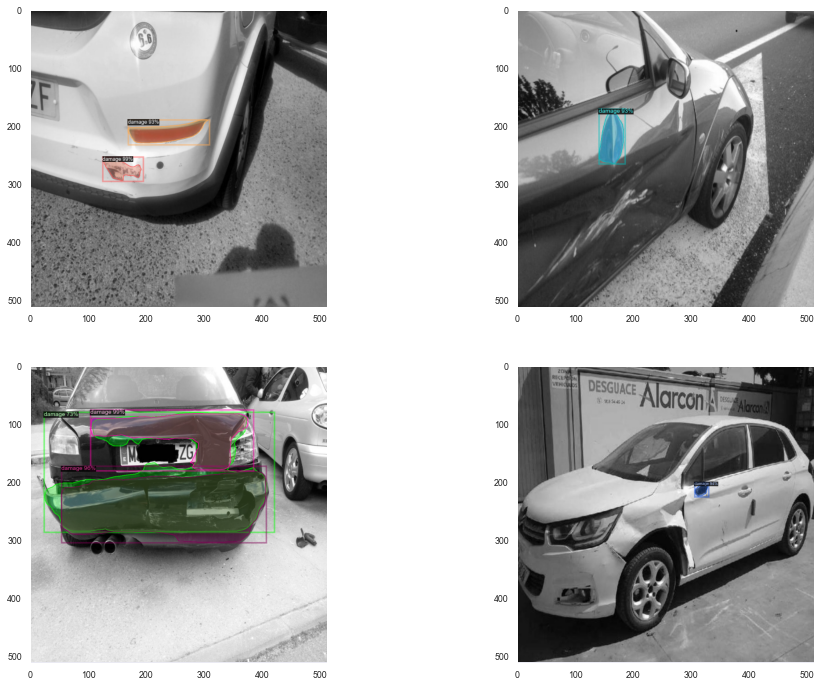

In [31]:
fig, ax = plt.subplots(2, 2, figsize =(16,12))
indices=[ax[0][0],ax[1][0],ax[0][1],ax[1][1] ]
i=-1
for d in random.sample(val_dataset_dicts, 4):
    i=i+1    
    im = io.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata_dicts, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    indices[i].grid(False)
    indices[i].imshow(out.get_image()[:, :, ::-1])